
# Stacked Bidirectional LSTM Sentiment Classifie



In this notebook, we stack LSTM layers to classify IMDB movie reviews by their sentiment

### Load dependencies

In [1]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import Bidirectional 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 

### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/stackedLSTM'

# training:
epochs = 20
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 200 
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# LSTM layer architecture:
n_lstm_1 = 64 # lower
n_lstm_2 = 64 # new!
drop_lstm = 0.2

### Load data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

17464789/17464789 [==============================] - 0s 0us/step


### Preprocess data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

### Design neural network architecture

In [5]:
model = Sequential()

model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))

# first LSTM layer:
model.add(Bidirectional(LSTM(n_lstm_1, dropout=drop_lstm, 
                             return_sequences=True)))

# second LSTM layer: 
model.add(Bidirectional(LSTM(n_lstm_2, dropout=drop_lstm)))

# Output layer:
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 64)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                        

### Configure model

In [7]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Train!

In [9]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/20
196/196 [==============================] - 34s 79ms/step - loss: 0.4642 - accuracy: 0.7718 - val_loss: 0.3565 - val_accuracy: 0.8498
Epoch 2/20
196/196 [==============================] - 14s 70ms/step - loss: 0.2790 - accuracy: 0.8871 - val_loss: 0.3351 - val_accuracy: 0.8576
Epoch 3/20
196/196 [==============================] - 18s 92ms/step - loss: 0.2214 - accuracy: 0.9154 - val_loss: 0.3720 - val_accuracy: 0.8658
Epoch 4/20
196/196 [==============================] - 15s 75ms/step - loss: 0.1751 - accuracy: 0.9347 - val_loss: 0.3375 - val_accuracy: 0.8688
Epoch 5/20
196/196 [==============================] - 15s 75ms/step - loss: 0.1465 - accuracy: 0.9469 - val_loss: 0.3875 - val_accuracy: 0.8672
Epoch 6/20
196/196 [==============================] - 14s 72ms/step - loss: 0.1182 - accuracy: 0.9574 - val_loss: 0.4283 - val_accuracy: 0.8565
Epoch 7/20
196/196 [==============================] - 14s 72ms/step - loss: 0.0987 - accuracy: 0.9666 - val_loss: 0.6490 - val_accuracy:

### Evaluate

In [10]:
model.load_weights(output_dir+"/weights.02.hdf5") 

In [12]:
y_hat = model.predict(x_valid)

782/782 [==============================] - 13s 15ms/step


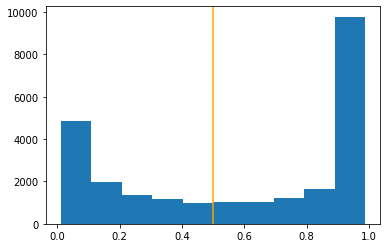

In [13]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [14]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'94.71'